In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,random_split
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import matplotlib.pyplot as plt
from torch.nn.functional import relu
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import Lambda
import numpy as np
import torch.optim as optim
import random

# Dataset

In [2]:
transform = Compose([
    Resize((256, 256)),
    ToTensor()
])

def rescale_mask(mask):
    return (mask * 255 - 1).long()

target_transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Lambda(rescale_mask)
])
data_dir = "./dogs_cats"
train_dataset = OxfordIIITPet(root=data_dir, split='trainval', transform=transform, target_transform=target_transform, download=True, target_types='segmentation')

Check structure and unique values for segmentation mask

In [3]:
img,mask = train_dataset[0]
print(len(train_dataset))
print(img.shape)
print(mask.shape)

print(mask.min())
print(mask.max())

3680
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
tensor(0)
tensor(2)


In [4]:
# Check unique values for segmentation mask
unique_values = set()

for _, mask in train_dataset:
    unique_values.update(torch.unique(mask).tolist())

print(unique_values)

{0, 1, 2}


/home/kris/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


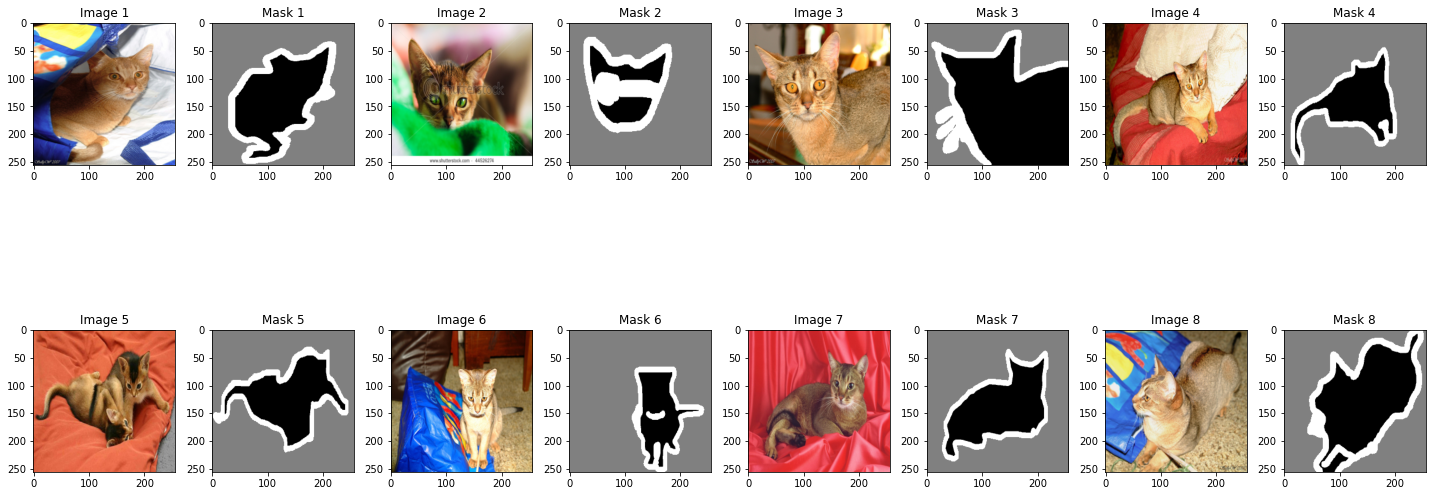

In [5]:
def visualize_dataset_with_masks(dataset, n_rows=2, n_cols=4, resize_dim=(256, 256)):
    fig, axes = plt.subplots(n_rows, 2*n_cols, figsize=(20, 10))
    
    resize_transform = Resize(resize_dim)
    
    for i in range(n_rows):
        for j in range(n_cols):
            idx = i * n_cols + j
            img, mask = dataset[idx]

            img = resize_transform(img)
            mask = resize_transform(mask)
            
            # Convert to numpy from [C,H,W] to [H,W,C]
            img_np = img.numpy().transpose((1, 2, 0))
            
            # Convert to numpy from [1,H,W] to [H,W]
            mask_np = np.array(mask).squeeze(0)
            
            # Display image
            axes[i, 2*j].imshow(img_np)
            axes[i, 2*j].set_title(f"Image {idx+1}")
            
            # Display mask
            axes[i, 2*j+1].imshow(mask_np, cmap='gray')
            axes[i, 2*j+1].set_title(f"Mask {idx+1}")
    
    plt.tight_layout()
    plt.show()

visualize_dataset_with_masks(train_dataset)

# U-net model

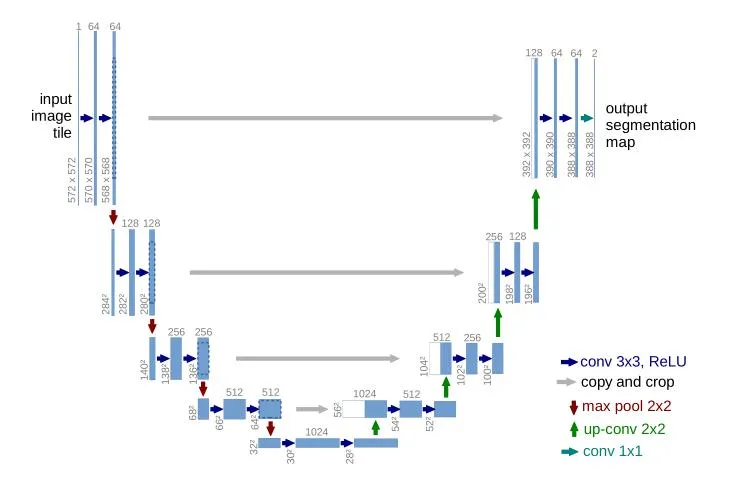

In [6]:
from IPython.display import Image
Image(filename='unet.png') 

In [7]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvolutionBlock, self).__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.convolution(x)

class UNetModel(nn.Module):
    def __init__(self, in_channel=3, out_channel=1, features=[64,128,256,512]):
        super(UNetModel, self).__init__()

        # Encoder
        self.encoder_layers = nn.ModuleList()
        for feature in features:
            self.encoder_layers.append(
                ConvolutionBlock(in_channel, feature)
            )
            in_channel=feature

        # Decoder
        self.decoder_layers = nn.ModuleList()
        for feature in reversed(features):
            self.decoder_layers.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder_layers.append(
                ConvolutionBlock(feature*2, feature)
            )

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.connected_layer = ConvolutionBlock(features[-1], features[-1]*2)
        self.output_layer = nn.Conv2d(features[0], out_channel, kernel_size=1)


    def forward(self, x):
        skip_connections = []

        # Encoder
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
            skip_connections.append(x)
            x = self.max_pool(x)

        # Encoder/Decoder connection
        x = self.connected_layer(x)

        # Reverse the skip connections for use in the decoder
        skip_connections = skip_connections[::-1]

        # Iterate over pairs of decoder layers and skip connections
        for (decoder_layer, transpose_layer), skip_connection in zip(self._pairwise(self.decoder_layers), skip_connections):
            # Upsample the feature map
            x = decoder_layer(x)
            
            # Concatenate the upsampled feature map with the skip connection
            concat_skip = torch.cat((skip_connection, x), dim=1)
            
            # Apply the convolution block
            x = transpose_layer(concat_skip)

        # Output
        out = self.output_layer(x)

        return out

    def _pairwise(self, iterable):
        """Helper function to iterate over pairs of elements in an iterable."""
        it = iter(iterable)
        return zip(it, it)

In [8]:
def test_model():
    x = torch.randn((3,1,256,256))
    model = UNetModel(in_channel=1, out_channel=1)
    predictions = model(x)
    try:
        assert predictions.shape == x.shape
        print("Test passed!")
    except AssertionError:
        print("Test failed!")
        print(f"Expected shape: {x.shape}, but got: {predictions.shape}")

test_model()

Test passed!


# Training

In [9]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
BATCH_SIZE = 16

In [10]:
train_dataset = OxfordIIITPet(root=data_dir, split='trainval', transform=transform, target_transform=target_transform, download=True, target_types='segmentation')
test_dataset = OxfordIIITPet(root=data_dir, split='test', transform=transform, target_transform=target_transform, download=True, target_types='segmentation')

# Split the train_dataset into train and validation
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
actual_train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(actual_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [11]:
model = UNetModel(in_channel=3, out_channel=3)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()  # Suitable for segmentation tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs=50

train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):

    # Training mode
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE) 

        optimizer.zero_grad()
        outputs = model(images)
        masks = masks.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    
    # Validation mode
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_pixels = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)  
            outputs = model(images)
            masks = masks.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == masks).sum().item()
            total_pixels += masks.numel()
    val_loss /= len(val_loader)
    val_accuracy = correct_predictions / total_pixels
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Test mode
    model.eval()
    test_loss = 0.0
    correct_predictions_test = 0
    total_pixels_test = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)  
            outputs = model(images)
            masks = masks.squeeze(1)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions_test += (predicted == masks).sum().item()
            total_pixels_test += masks.numel()
    test_loss /= len(test_loader)
    test_accuracy = correct_predictions_test / total_pixels_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50, Validation Loss: 0.8398, Validation Accuracy: 0.6101, Test Loss: 0.8306, Test Accuracy: 0.6161
Epoch 2/50, Validation Loss: 0.7138, Validation Accuracy: 0.7096, Test Loss: 0.7259, Test Accuracy: 0.7102
Epoch 3/50, Validation Loss: 0.6725, Validation Accuracy: 0.7395, Test Loss: 0.6769, Test Accuracy: 0.7363
Epoch 4/50, Validation Loss: 0.5205, Validation Accuracy: 0.7990, Test Loss: 0.5219, Test Accuracy: 0.7974
Epoch 5/50, Validation Loss: 0.4708, Validation Accuracy: 0.8191, Test Loss: 0.4705, Test Accuracy: 0.8178
Epoch 6/50, Validation Loss: 0.6287, Validation Accuracy: 0.7515, Test Loss: 0.5989, Test Accuracy: 0.7623
Epoch 7/50, Validation Loss: 0.6598, Validation Accuracy: 0.7301, Test Loss: 0.6452, Test Accuracy: 0.7359
Epoch 8/50, Validation Loss: 0.3940, Validation Accuracy: 0.8498, Test Loss: 0.3830, Test Accuracy: 0.8535
Epoch 9/50, Validation Loss: 0.3752, Validation Accuracy: 0.8581, Test Loss: 0.3660, Test Accuracy: 0.8625
Epoch 10/50, Validation Loss: 0.4063,

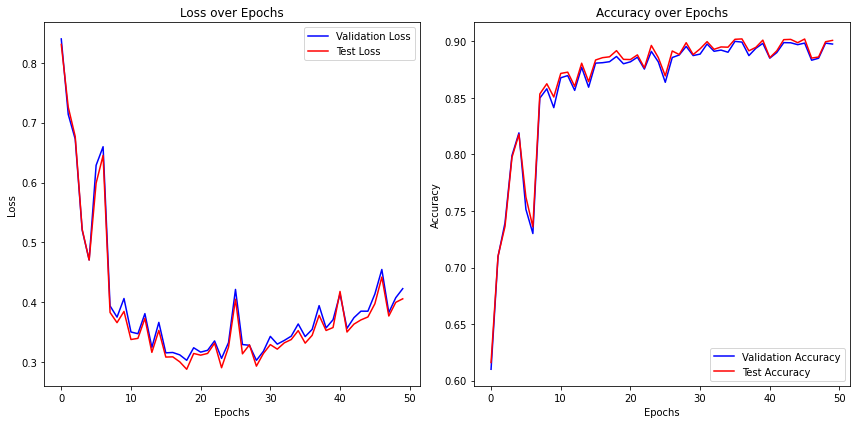

In [13]:
# Plotting Losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Validation Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Predictions

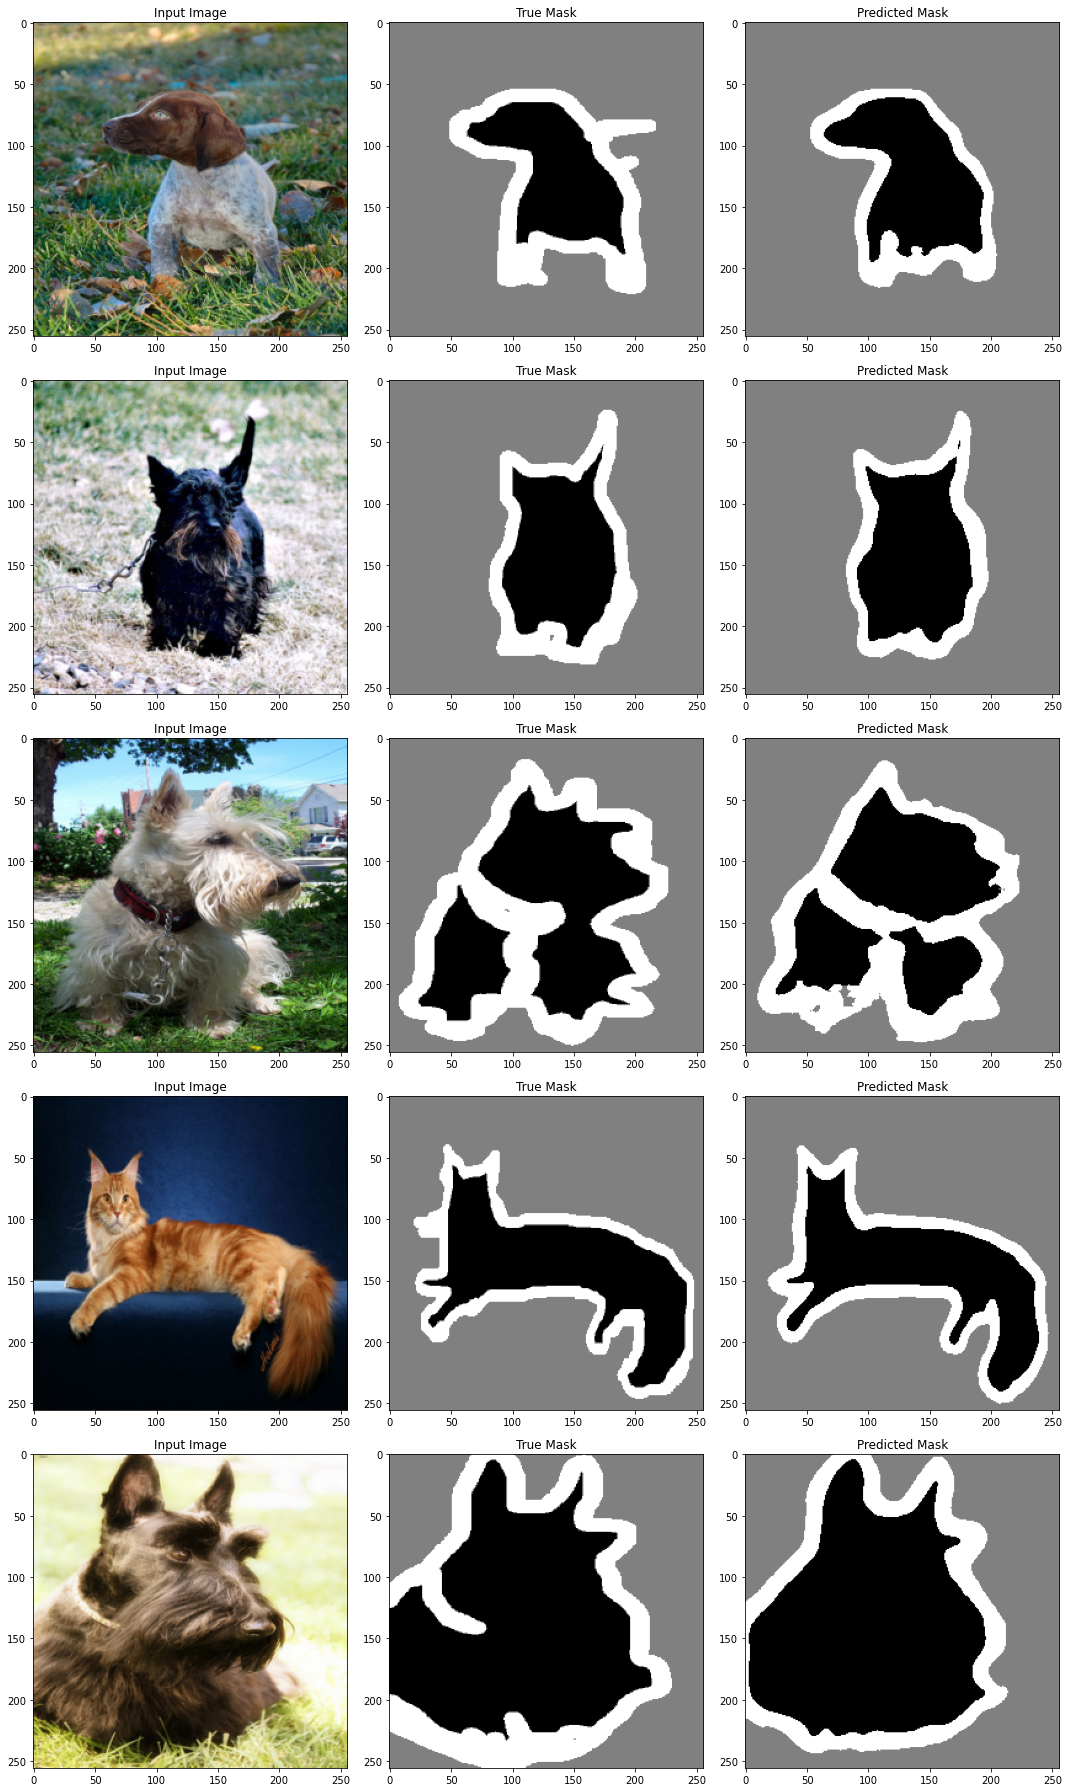

In [16]:
def display_predictions(model, dataset, num_samples=5, resize_dim=(256, 256)):
    model.eval()
    model.to(DEVICE)

    resize_transform = Resize(resize_dim)
    
    # Randomly select samples from the dataset
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i, idx in enumerate(indices):
        image, true_mask = dataset[idx]

        # Resize the image and mask for visualization
        image = resize_transform(image)
        true_mask = resize_transform(true_mask)
        
        # Add a batch dimension to the image tensor
        image_tensor = image.unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            pred_mask_logits = model(image_tensor)

        # Get the predicted class labels by taking the argmax over the out_channels dimension
        pred_mask = torch.argmax(pred_mask_logits, dim=1).squeeze(0).cpu().numpy()

        # Convert true_mask from PIL Image to numpy array
        true_mask = np.array(true_mask).squeeze(0)
        
        axs[i, 0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        axs[i, 0].set_title("Input Image")
        
        axs[i, 1].imshow(true_mask, cmap='gray')
        axs[i, 1].set_title("True Mask")
        
        axs[i, 2].imshow(pred_mask, cmap='gray')
        axs[i, 2].set_title("Predicted Mask")
        
    plt.tight_layout()
    plt.show()


display_predictions(model, test_dataset)
